## Notes

**Accessing Data**

data['data'] -> list with options data for all expiration dates<br>
data['data'][0]['options'] -> all call/put options for first expiration date<br>
data['data'][0]['options']['CALL'] -> all call options data for first expiration date<br>
data['data'][0]['options']['CALL'][0] -> first call option data for first expiration date<br>

Example Option Data for data['data'][0]['options']['CALL'][0]:

{'contractName': 'AAPL201231C00085000', 'contractSize': 'REGULAR', 'currency': 'USD', 'type': 'CALL', 'inTheMoney': 'TRUE', 'lastTradeDateTime': '2020-12-23 10:32:03', 'expirationDate': '2020-12-31', 'strike': 85, 'lastPrice': 46.55, 'bid': 46.85, 'ask': 47.15, 'change': 5.2, 'changePercent': 0.1258, 'volume': 39, 'openInterest': 182, 'impliedVolatility': 100.0435, 'delta': 0.9994, 'gamma': 0.0001, 'theta': -0.0065, 'vega': 0.0004, 'rho': 0.0163, 'theoretical': 47, 'intrinsicValue': 0, 'timeValue': 0, 'updatedAt': '2020-12-24 19:16:06', 'daysBeforeExpiration': 6}

## Imports

In [1]:
import numpy as np
import pandas as pd
# import xslswriter
import requests
# from scipy import status
import math
import matplotlib.pyplot as plt
import datetime

In [2]:
from secrets import IEX_CLOUD_API_TOKEN, EOD_HISTORICAL_DATA_API_TOKEN

## Functions

**Function: createDatesStringArray**<br>

Creates a string array of dates with given start date, difference between them (default: 1 week), and the size of
the array. The start date is inclusive

In [3]:
def createDatesStringArray(startDate = datetime.date.today(), deltaDays = 7, N = 5):
    nextDate = startDate
    datesStringArray = []
    for i in range(N):
        datesStringArray.append(str(nextDate))
        tdelta = datetime.timedelta(days=deltaDays)
        nextDate = nextDate + tdelta
    return(datesStringArray)

**Function: createOptionsArrays**

Returns an array of breakeven prices, strike prices, and last prices for options of a specific type. The arrays are in the same order. Only includes the values for which the difference between the strike and current value of the stock is below a threshold (default: +/- 25%) AND only includes In The Money Options

In [4]:
def createOptionsArrays(data, optionType, maxDelta=0.25):
    
    latestPrice = data['lastTradePrice']
    optionsData = data['data'][0]['options'][optionType]
    
    breakEvensArray = []
    strikeArray = []
    lastPriceArray = []

    for option in optionsData:
        
        strike = option['strike']
        lastPrice = option['lastPrice']
        breakeven = strike + lastPrice
        breakEvenPercent = abs(strike - latestPrice)/latestPrice
        
        if optionType == 'CALL':
            if (strike > latestPrice) and (breakEvenPercent < maxDelta):
                breakEvensArray.append(breakeven)
                strikeArray.append(strike)
                lastPriceArray.append(lastPrice)
                
        if optionType == 'PUT':
            if (strike < latestPrice) and (breakEvenPercent < maxDelta):
                breakEvensArray.append(breakeven)
                strikeArray.append(strike)
                lastPriceArray.append(lastPrice)
    
    return breakEvensArray, strikeArray, lastPriceArray

**Function: createOptionStrikesVPricePlot**

This function creates the options strikes vs price plots for the specified symbol and date.

In [5]:
def createOptionStrikesVPricePlot(data, title):
    
    # Parse the data
    latestPrice = data['lastTradePrice']
    callBreakEvensArray, callStrikeArray, callLastPriceArray = createOptionsArrays(data, 'CALL')
    putBreakEvensArray, putStrikeArray, putLastPriceArray = createOptionsArrays(data, 'PUT')
    
    # Create the plots
    fig1, ax1 = plt.subplots()
    ax1.plot(callStrikeArray, callLastPriceArray, label='CALLS')
    ax1.plot(putStrikeArray, putLastPriceArray, label='PUTS')
    ax1.axvline(x=latestPrice, label='Last Price', linewidth=2, color='r')
    
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Premium')
    ax1.legend()
    ax1.set_title(title)

## Main Run

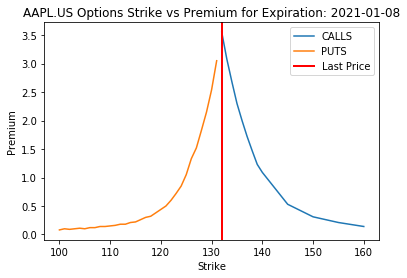

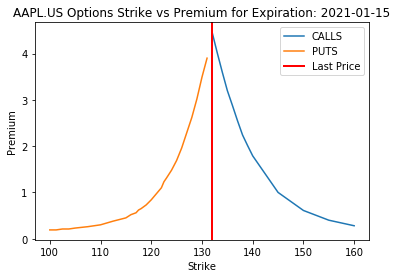

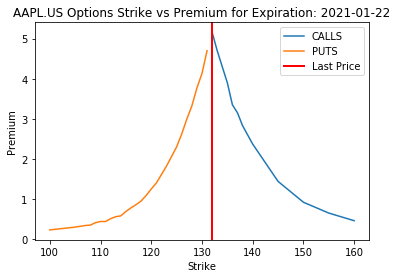

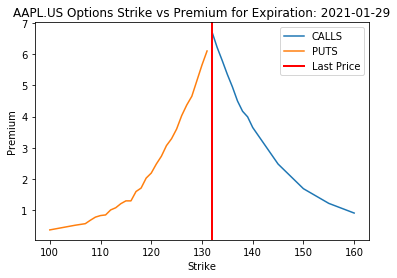

In [6]:
# List of symbols to loop over
symbols = ['AAPL.US']

# List of Expiration dates to loop over
expirationDates = createDatesStringArray(datetime.date(2021, 1, 8), 7, 5)

# Loop over all symbols and dates
for symbol in symbols:
    
    for date in expirationDates:
        
        # Make the API call
        api_base_url = 'https://eodhistoricaldata.com/api/'
        api_endpoint_url = f'options/{symbol}/'
        api_token_url = f'?api_token={EOD_HISTORICAL_DATA_API_TOKEN}'
        api_optional_url = f'&from={date}&to={date}'

        api_url = api_base_url + api_endpoint_url + api_token_url + api_optional_url
        
        data = requests.get(api_url).json()

        # Create the plot if the expiration date has any options data
        if data['data'] != []:
            title = f'{symbol} Options Strike vs Premium for Expiration: {date}'
            createOptionStrikesVPricePlot(data, title)